# Module 1 Project: King County House Sales Price Projection


#### Follow the OSEMN model process in this project:

-   Obtain **
-   Scrub **
-   Explore **
-   Model **
-  Interpret **

# I. Obtain the data 


In [106]:
#import libraries and data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import norm
import statsmodels.formula.api as smf
import scipy.stats as stats
from collections import Counter
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from statsmodels.formula.api import ols
%matplotlib inline



In [107]:
kcdata = pd.read_csv("kc_house_data.csv")

In [108]:
kcdata.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [109]:
kcdata.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

# II. Data Scrubbing



* Identify and deal with null values appropriately
* Cast columns to the appropriate data types
* Remove unnecessary columns
* Check for and deal with multicollinearity
* Normalize our data

### Deal with missing values

In [110]:
#Identify missing value: waterfront, view, yr_renovated, and incorrect data type: sqft_basement
kcdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


In [111]:
kcdata.isnull().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [112]:
#For Categorical data 'Waterfront', replace NAN with mode 0 since it is highly possible that the house doesn't have a waterfront. 
kcdata['waterfront'].value_counts()
kcdata['waterfront'] = kcdata['waterfront'].fillna(0)

counter = Counter()
counter = Counter(kcdata['waterfront'])
print(counter)

Counter({0.0: 21451, 1.0: 146})


For view, this variable presents how many times people have viewed the house. Majority of the values are zero. So we will replace NAN with 0.

In [113]:
kcdata['view'].unique()
kcdata['view'] = kcdata['view'].fillna(0)
counter = Counter()
counter = Counter(kcdata['view'])
print(counter)


Counter({0.0: 19485, 2.0: 957, 3.0: 508, 1.0: 330, 4.0: 317})


In [114]:
#There are too many missing values in yr_renovated. And it may not be fair to replace NAN with average. 
#So we will probably not consider this variable into the model.We will fill NaN and remove this column now.
%matplotlib inline
kcdata['yr_renovated'].fillna(0);

In [115]:
kcdata.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.006760,0.233181,3.409825,7.657915,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.081944,0.764673,0.650546,1.173200,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [116]:
kcdata.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront          0
view                0
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

### Cast columns to the appropriate data types

Obvious fix: change date from string to datetime, sqft_basement to continuous, waterfront as categorical

Condition and grade are ordinal variables with limited values. View and Floors have limited values too. Can group them into bins. 

In [117]:
#Convert strings into dates
from datetime import datetime
kcdata['date'].head()
f = lambda x: datetime.strptime(x,'%m/%d/%Y')
kcdata['date']=kcdata['date'].apply(f)
kcdata.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [118]:
#Convert sqft_basement column from string to numerical
kcdata['sqft_basement'].value_counts()

#Replace ? with zeros for now.
kcdata['sqft_basement'] = kcdata['sqft_basement'].replace('?','0')


kcdata['sqft_basement'] = kcdata['sqft_basement'].astype(float)
kcdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null datetime64[ns]
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       21597 non-null float64
view             21597 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null float64
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: datetime64[ns](1), float64(9), int64(11)
memory usage: 3.5

## III. Data Exploration

From the data dictionary below we can probably tell some are continuous variables (footage of the home/lot/basement/yr_built) and some might be numerical but more like categorical (number of bathrooms/bedrooms, waterfront, view, condition, grade), and other variables we are not sure (zipcode,lat,long). We will visualize them next.

* **id** - unique identified for a house
* **dateDate** - house was sold
* **pricePrice** -  is prediction target
* **bedroomsNumber** -  of Bedrooms/House
* **bathroomsNumber** -  of bathrooms/bedrooms
* **sqft_livingsquare** -  footage of the home
* **sqft_lotsquare** -  footage of the lot
* **floorsTotal** -  floors (levels) in house
* **waterfront** - House which has a view to a waterfront
* **view** - Has been viewed
* **condition** - How good the condition is ( Overall )
* **grade** - overall grade given to the housing unit, based on King County grading system
* **sqft_above** - square footage of house apart from basement
* **sqft_basement** - square footage of the basement
* **yr_built** - Built Year
* **yr_renovated** - Year when house was renovated
* **zipcode** - zip
* **lat** - Latitude coordinate
* **long** - Longitude coordinate
* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors

#### House Price change over Time

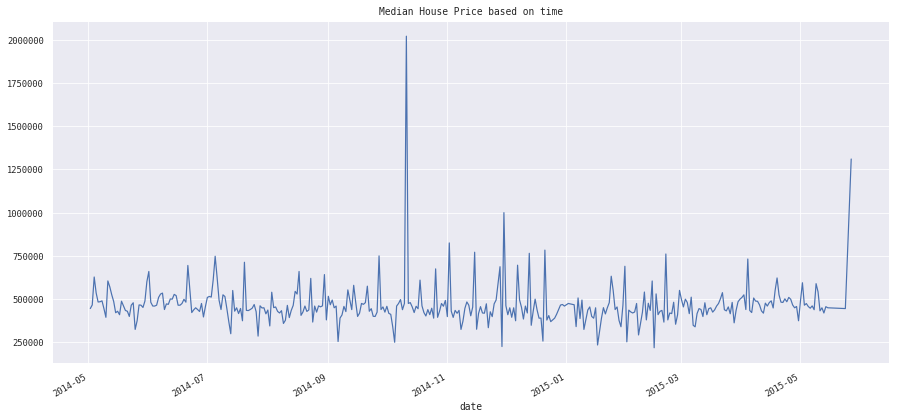

In [119]:
temp = kcdata['price'].groupby([kcdata['date']]).median()
temp.index = pd.to_datetime(temp.index)
temp.plot(figsize=(15,7),title='Median House Price based on time')
plt.show()

#### Areas with top house price

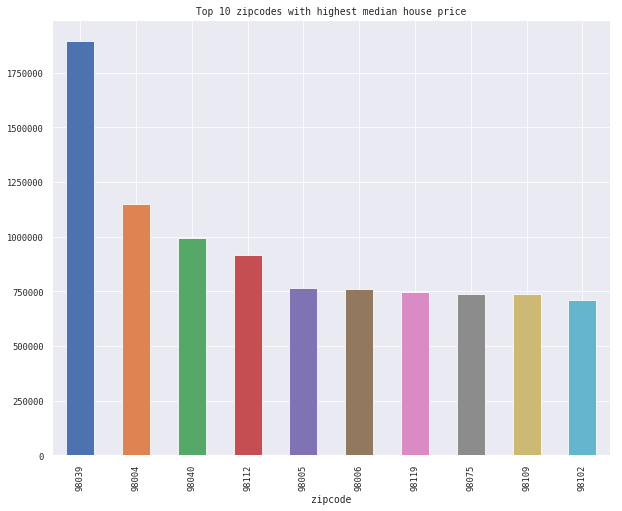

In [120]:
temp = kcdata['price'].groupby([kcdata['zipcode']]).median()
temp = temp.sort_values(ascending=False)[:10]
temp.plot(kind='bar',figsize=(10,8), title='Top 10 zipcodes with highest median house price')
plt.show()

<img src='map.png'>

In [121]:
kcdata['price'].groupby([kcdata['zipcode']]).mean();

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

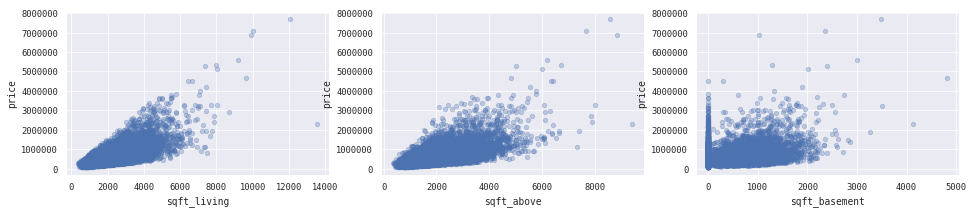

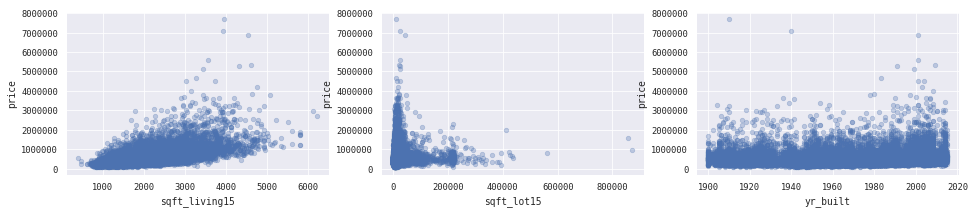

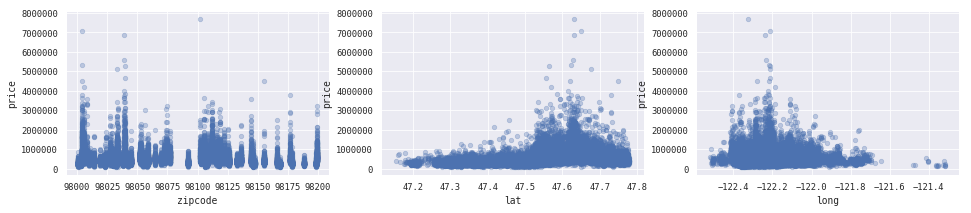

In [122]:
#Plotting potential continuous variables

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,3))
con_list = ['sqft_living','sqft_above','sqft_basement']

for xcol, ax in zip(con_list, axes):
    kcdata.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.3)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,3))
con_list2 =['sqft_living15','sqft_lot15','yr_built']

for xcol, ax in zip(con_list2, axes):
    kcdata.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.3)
    
#Plotting zipcode

fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(16,3))
geo_list = ['zipcode','lat','long']

for xcol, ax in zip(geo_list, axes):
    kcdata.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.3)


Observation: From the scattered plots above, we can tell sqft_living, sqft_above, sqft_living15 have positive correlation with house price, while yr_built and zipcode do not have obvious relationship with house price. Also from the plot, we can tell that the shape of sqft_living and sqft_living15 are similar while sqft_lot and sqft_lot15 are very similar too. So probably these two sets of variables are highly correlated.

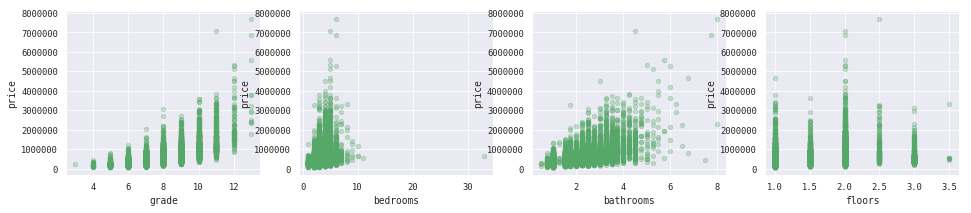

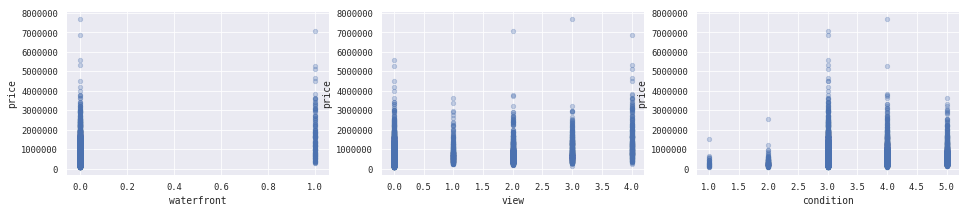

In [123]:
#Plotting other variables. Waterfront is clearly categorical values with binominal values. 
#While view, condition, grade, bedrooms, bathrooms, and floors present actual numerical values so we can either keep them numerical or transform them into categorical values. 

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))
cat_list1 = ['grade','bedrooms', 'bathrooms','floors']


for xcol, ax in zip(cat_list1, axes):
    kcdata.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.3, color='g')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,3))    
cat_list2=['waterfront', 'view', 'condition']
for xcol, ax in zip(cat_list2, axes):
    kcdata.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.3, color='b')

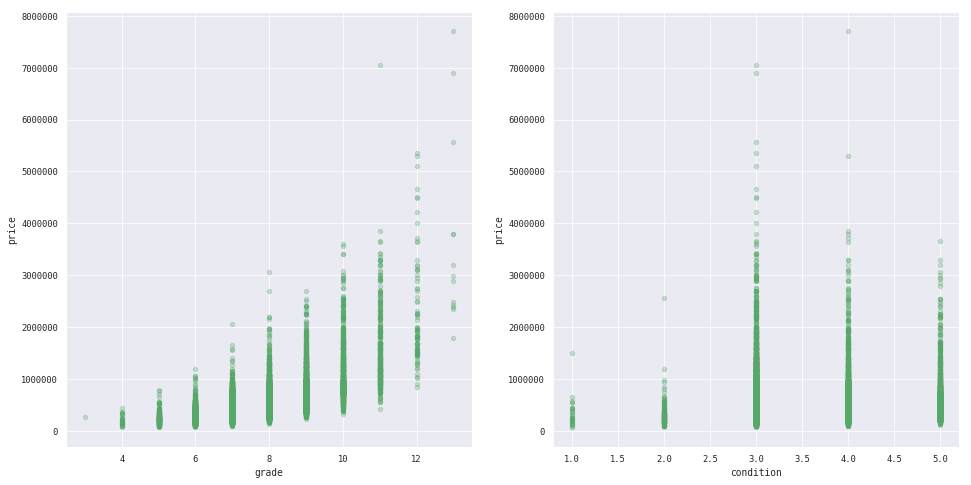

In [124]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
cat_list1 = ['grade','condition']


for xcol, ax in zip(cat_list1, axes):
    kcdata.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.3, color='g')



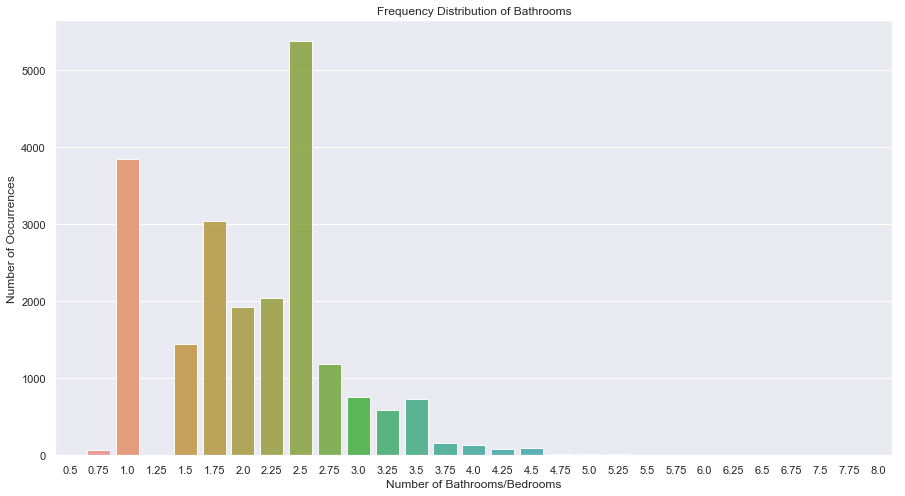

In [125]:
#Value Counts 
#bathroomsNumber - of bathrooms/bedrooms

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
bathroom_count = kcdata['bathrooms'].value_counts()
sns.set(style="darkgrid")
plt.figure(figsize=(15,8))
sns.barplot(bathroom_count.index, bathroom_count.values, alpha=0.9)

plt.title('Frequency Distribution of Bathrooms')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of Bathrooms/Bedrooms', fontsize=12)
plt.show()

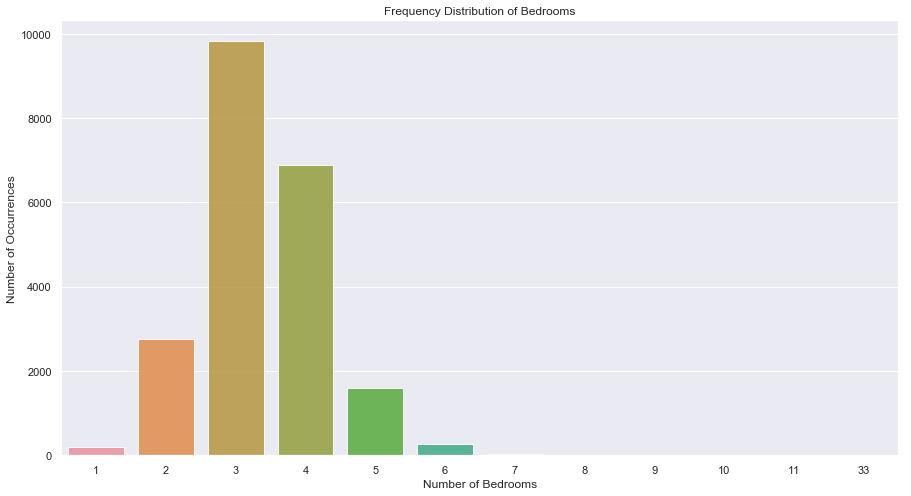

In [126]:
bedroom_count = kcdata['bedrooms'].value_counts()
sns.set(style="darkgrid")
plt.figure(figsize=(15,8))
sns.barplot(bedroom_count.index, bedroom_count.values, alpha=0.9)

plt.title('Frequency Distribution of Bedrooms')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of Bedrooms', fontsize=12)
plt.show()

#### Outliers in Bedroom

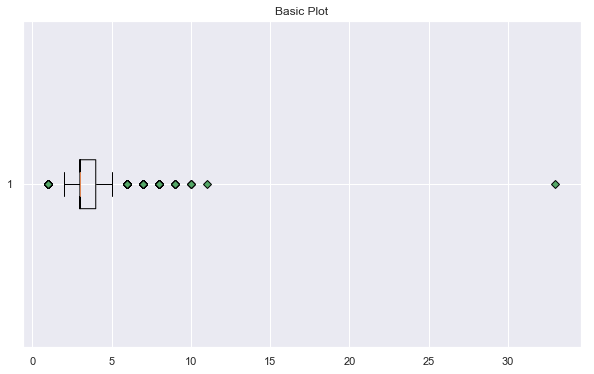

In [127]:
fig1, ax1 = plt.subplots(figsize=(10,6))
green_diamond = dict(markerfacecolor='g', marker='D')
ax1.set_title('Basic Plot')
ax1.boxplot(kcdata['bedrooms'], notch=True, flierprops=green_diamond, vert=False)
plt.show()

We should at least remove the far right point.

## Correlation Matrix

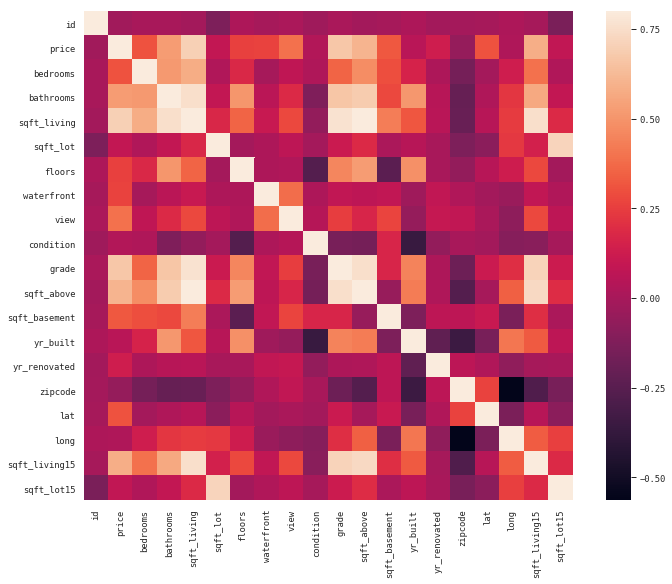

In [128]:
sns.set(context='paper', font='monospace')
corrmat = kcdata.corr()


f, ax = plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.8, square=True);

Analyzing the heatmap, the variables that are highly correlated to price are:
* sqft_living
* sqft_above
* grade

Independent variables which are highly correlated with each other:

* sqft_living with sqft_living15, bathroom, grade, sqft_above
* grade with bathroom, sqft_above, sqft_living15, sqft_living

## Check Multicolinearity 

In [129]:
## Check Multicolinearity 

kcdata_set = kcdata.iloc[:,3:-1]
kcdata_set.head()
kcdata_set.corr()
abs(kcdata_set.corr()) > 0.75

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15
bedrooms,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bathrooms,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
sqft_living,False,True,True,False,False,False,False,False,True,True,False,False,False,False,False,False,True
sqft_lot,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
floors,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
waterfront,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
view,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
condition,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
grade,False,False,True,False,False,False,False,False,True,True,False,False,False,False,False,False,False
sqft_above,False,False,True,False,False,False,False,False,True,True,False,False,False,False,False,False,False


The correlation matrix confirms the observation that sqft_living are highly correlated with bathrooms, grade, sqft_above, sqft_living15.

Multicolinearity exists here.

We will drop sqft_living15, sqft_lot15 because they are highly correlated with sqft_living and sqft_lot, and also zipcode, lat, long.

### Turn view to binary variable

In [130]:
kcdata['view']=kcdata['view'].fillna(0)
kcdata['view'] = kcdata['view'].astype(int)

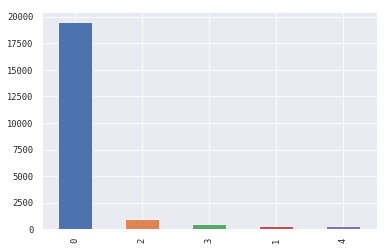

In [131]:
kcdata['view'].value_counts().plot(kind='bar')

In [132]:
kcdata['view'].describe()

count    21597.000000
mean         0.233181
std          0.764673
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.000000
Name: view, dtype: float64

Since more than 75% values are 0, it might make sense to create a binary variable "viewed".

In [133]:
kcdata['viewed'] = pd.Series(len(kcdata['price']), index=kcdata.index)
kcdata['viewed'] = 0
kcdata.loc[kcdata['view']>0,'viewed']=1
viewed_dummy = pd.get_dummies(kcdata['viewed'], prefix ='view')

## Turn condition to dummy columns

(-0.5, 4.5, 0, 8000000)

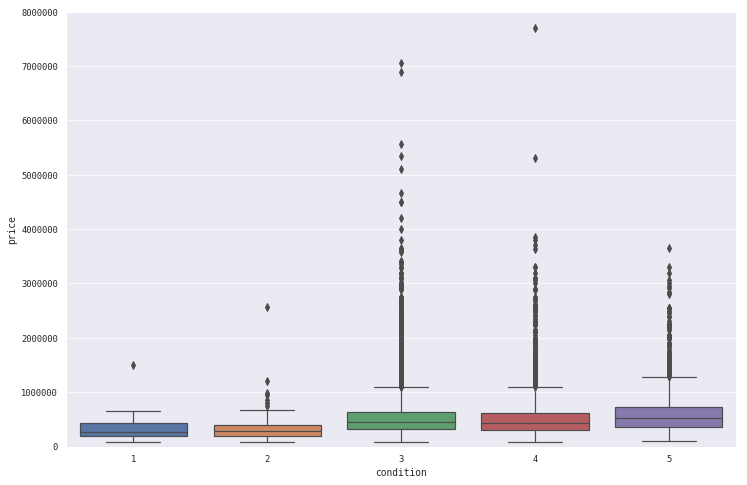

In [134]:
data = pd.concat([kcdata['price'], kcdata['condition']], axis=1)
f, ax = plt.subplots(figsize=(12,8))
fig = sns.boxplot(x='condition', y='price', data=data)
fig.axis(ymin=0, ymax=8000000)

In [135]:
condition_dummies = pd.get_dummies(kcdata['condition'], prefix='con')

In [136]:

condition_dummies.head(10)

,con_1,con_2,con_3,con_4,con_5
0,0,0,1,0,0
1,0,0,1,0,0
2,0,0,1,0,0
3,0,0,0,0,1
4,0,0,1,0,0
5,0,0,1,0,0
6,0,0,1,0,0
7,0,0,1,0,0
8,0,0,1,0,0
9,0,0,1,0,0


## Convert Waterfront to binominal 

In [137]:
waterfront_dummy = pd.get_dummies(kcdata['waterfront'], prefix ='waterfront')

## Explore grade, bedrooms, bathrooms, years and floors

Although grade, bedrooms, bathrooms and floors are numerical values, it is diffidult to justify a linear pattern between these variables and target here. For example, grade 2 may not mean it is twice better than grade 1, or worse. It might make sense to restructure data into bins so that they are treated as categorical variables.

#### GRADE

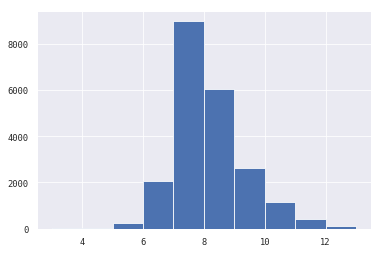

In [138]:
kcdata['grade'].describe()
kcdata['grade'].hist()

(-0.5, 10.5, 0, 8000000)

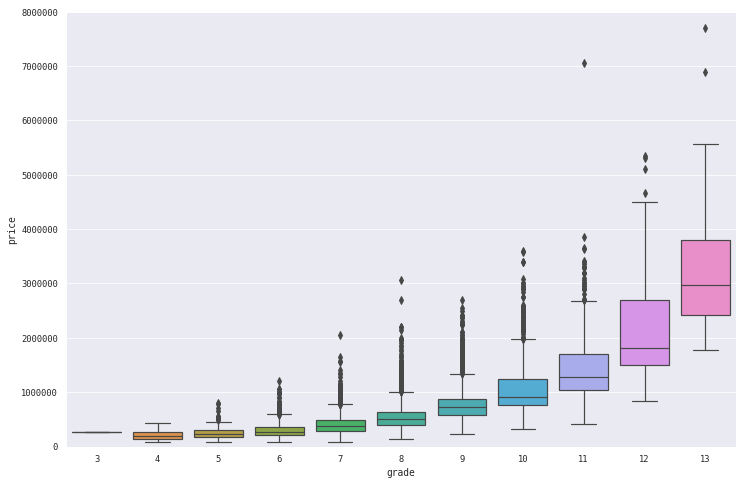

In [139]:
data = pd.concat([kcdata['price'], kcdata['grade']], axis=1)
f, ax = plt.subplots(figsize=(12,8))
fig = sns.boxplot(x='grade', y='price', data=data)
fig.axis(ymin=0, ymax=8000000)

Boxplot shows obvious exponential relationship between grade and price. We will keep all grades and create dummy variables.

In [140]:
grade_dummy = pd.get_dummies(kcdata['grade'], prefix='grade')

#### BEDROOMS

In [141]:
kcdata['bedrooms'].describe()

count    21597.000000
mean         3.373200
std          0.926299
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max         33.000000
Name: bedrooms, dtype: float64

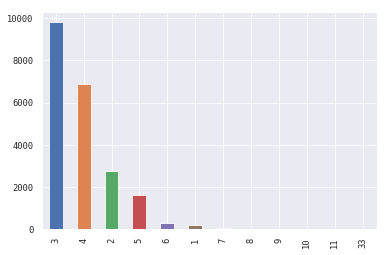

In [142]:
kcdata['bedrooms'].value_counts().plot(kind='bar')

There might be an outlier 33 in the bedroom variable. 

In [143]:
#The observation doesn't make sense, a house with 33 bedrooms only have 1040 sqft above the basement.
kcdata[kcdata['bedrooms']==33].sqft_above

15856    1040
Name: sqft_above, dtype: int64

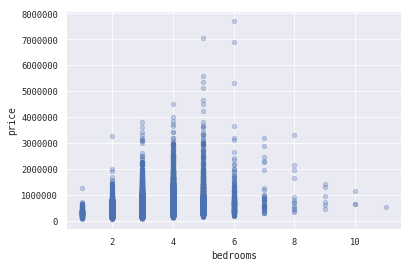

In [144]:
#Remove the max value from bedrooms
o = kcdata['bedrooms'].max()
kcdata = kcdata[kcdata['bedrooms']< o]
kcdata.plot(kind='scatter', x='bedrooms', y='price', alpha=0.3, color='b');


(-0.5, 10.5, 0, 8000000)

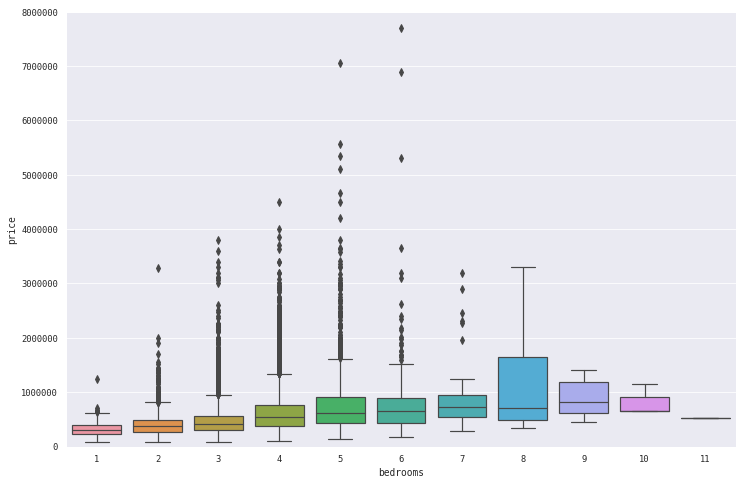

In [145]:

data = pd.concat([kcdata['price'], kcdata['bedrooms']], axis=1)
f, ax = plt.subplots(figsize=(12,8))
fig = sns.boxplot(x='bedrooms', y='price', data=data)
fig.axis(ymin=0, ymax=8000000)

In [146]:
kcdata['bedrooms'].describe()

count    21596.000000
mean         3.371828
std          0.904114
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max         11.000000
Name: bedrooms, dtype: float64

In [147]:
bins = [1,2,3,4,5,6,11]
bins_bedroom = pd.cut(kcdata['bedrooms'],bins)
bins_bedroom = bins_bedroom.cat.as_unordered()
bedroom_dummy = pd.get_dummies(bins_bedroom, prefix='bedroom')

#### BATHROOMS

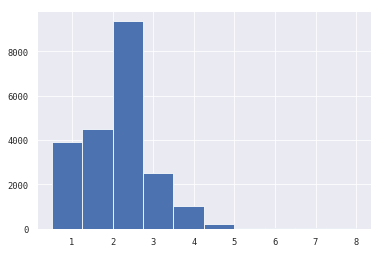

In [148]:
kcdata['bathrooms'].hist()
#kcdata['bathrooms'].value_counts();

The definition of 'bathrooms' is the number of bathrooms per bedrooms. Normally a residential building have 0.5-2 bathrooms per bedroom. So 3-8 bathrooms per bedroom may suggest there are different kinds of buildings. We can investigate the sqft_above and price to see if any outliers. 

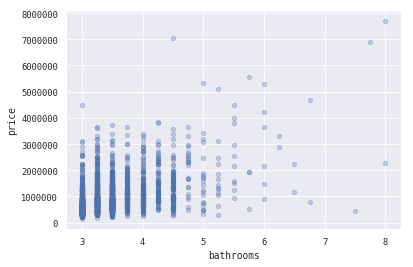

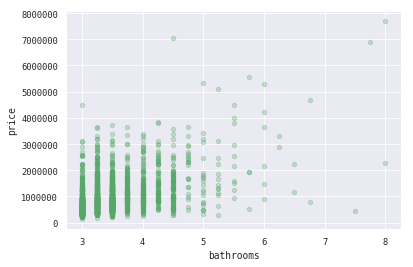

In [149]:
kcdata[kcdata['bathrooms']>=3].groupby('bathrooms').sqft_above.mean()
b = kcdata[kcdata['bathrooms']>=3]
b.plot(kind='scatter', x='bathrooms', y='price', alpha=0.3, color='b')
b.plot(kind='scatter', x='bathrooms', y='price', alpha=0.3, color='g')


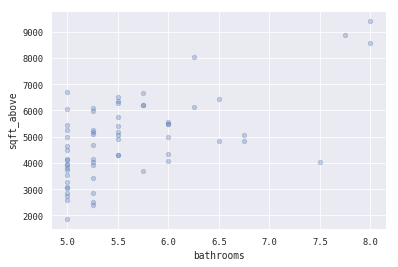

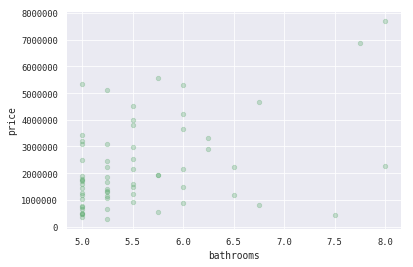

In [150]:
#Check bathrooms >5. 
kcdata[kcdata['bathrooms']>=5].groupby('bathrooms').sqft_above.mean()
a = kcdata[kcdata['bathrooms']>= 5]
a.plot(kind='scatter', x='bathrooms', y='sqft_above', alpha=0.3, color='b')
a.plot(kind='scatter', x='bathrooms', y='price', alpha=0.3, color='g')


We will create bins for bathrooms for now. 

In [151]:
bins = [0.5,1.5,2,2.5,5,8]
bins_bathroom = pd.cut(kcdata['bathrooms'],bins)
bins_bathroom = bins_bathroom.cat.as_unordered()
bathroom_dummy = pd.get_dummies(bins_bathroom, prefix='bathroom')

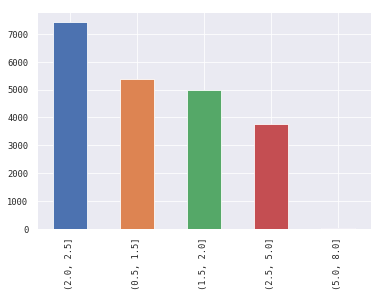

In [152]:
bins_bathroom.value_counts().plot(kind='bar')

#### FLOORS

In [153]:
kcdata['floors'].describe()

count    21596.000000
mean         1.494119
std          0.539685
min          1.000000
25%          1.000000
50%          1.500000
75%          2.000000
max          3.500000
Name: floors, dtype: float64

In [154]:
bins = [0,1,1.5,2,3.5]
bins_floors = pd.cut(kcdata['floors'],bins)
bins_floors = bins_floors.cat.as_unordered()
floors_dummy = pd.get_dummies(bins_floors, prefix = 'floors')

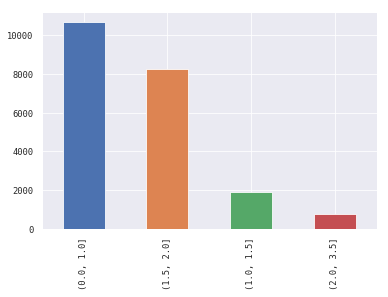

In [155]:
bins_floors.value_counts().plot(kind='bar')

#### Year Built

In [156]:
kcdata['yr_built'].describe()

count    21596.000000
mean      1971.000787
std         29.375460
min       1900.000000
25%       1951.000000
50%       1975.000000
75%       1997.000000
max       2015.000000
Name: yr_built, dtype: float64

(-0.5, 115.5, 0, 8000000)

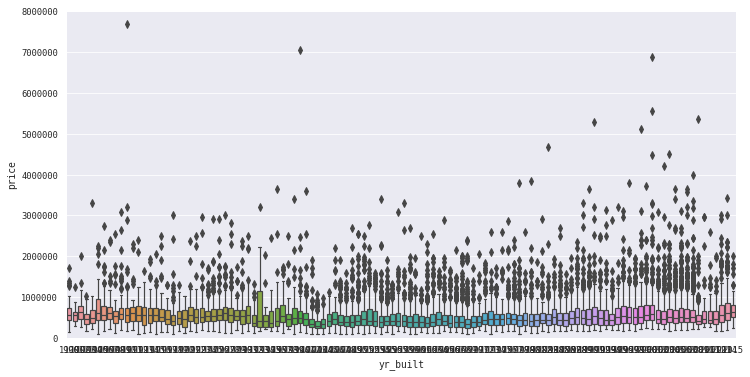

In [157]:
data = pd.concat([kcdata['price'], kcdata['yr_built']], axis=1)
f, ax = plt.subplots(figsize=(12,6))
fig = sns.boxplot(x='yr_built', y='price', data=data)
fig.axis(ymin=0, ymax=8000000)

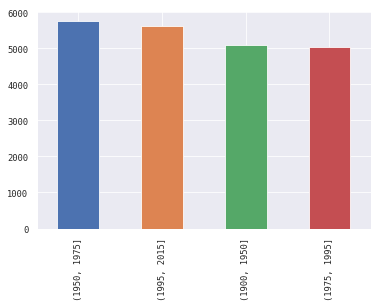

In [158]:
bins = [1900,1950,1975,1995,2015]
bins_year = pd.cut(kcdata['yr_built'],bins)
bins_year = bins_year.cat.as_unordered()
bins_year.head()
year_dummy=pd.get_dummies(bins_year, prefix='year')

bins_year.value_counts().plot(kind='bar')

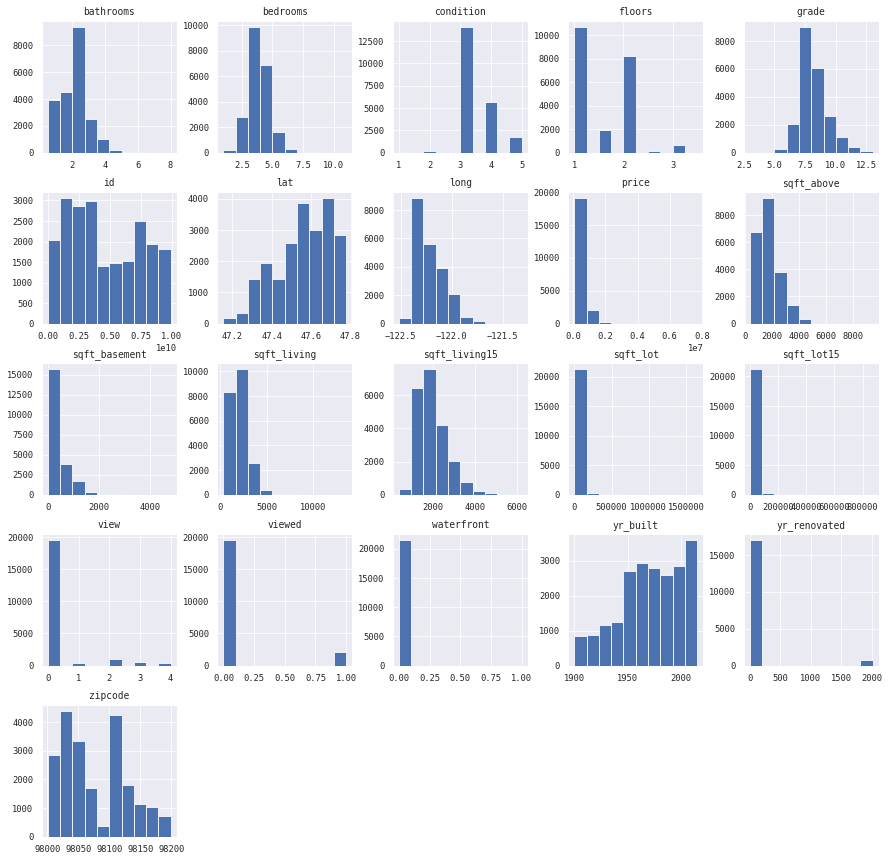

In [159]:
kcdata.hist(figsize=[15,15]);

## Feature Scaling and Normalization

In [160]:
zipcode_dummies = pd.get_dummies(kcdata['zipcode'], prefix='zipcode')
year_dummies=pd.get_dummies(kcdata['yr_built'], prefix='year')

In [161]:
kcdata = pd.concat([kcdata, grade_dummy, floors_dummy, viewed_dummy, bedroom_dummy, bathroom_dummy, condition_dummies, waterfront_dummy, year_dummies, zipcode_dummies], axis=1)

In [162]:
kcdata_set = kcdata.drop(['yr_built', 'yr_renovated', 'grade', 'floors', 'view','sqft_living15','sqft_lot15','viewed', 'zipcode', 'bedrooms','bathrooms','lat','long','condition','waterfront'], axis=1)

In [165]:
kcdata_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21596 entries, 0 to 21596
Columns: 228 entries, id to zipcode_98199
dtypes: datetime64[ns](1), float64(207), uint8(20)
memory usage: 34.8 MB


In [164]:
kcdata_set.dropna(inplace=True)

 
Variables with lepto kurtosis: price, sqft_lot
Variables with either positive or negative Skewness: sqft_above, sqft_living

We will perform log transformation to variables with skewness and then do mean normalization. 

### Log Transformation on sqft_above and sqft_living

In [166]:
kcdata_log = pd.DataFrame([])
kcdata_log['sqft_above']=np.log(kcdata_set['sqft_above'])
kcdata_log['sqft_living']=np.log(kcdata_set['sqft_living'])
kcdata_log['price']=np.log(kcdata_set['price'])

In [167]:
basement = kcdata_set['sqft_basement']
lot = kcdata_set['sqft_lot']
logabove = kcdata_log['sqft_above']
logliving = kcdata_log['sqft_living']
logprice = kcdata_log['price']


scaled_basement= (basement - min(basement))/(max(basement) - min(basement))
scaled_lot = (lot - min(lot))/(max(lot) - min(lot))
scaled_above = (logabove - np.mean(logabove))/np.sqrt(np.var(logabove))
scaled_living = (logliving - np.mean(logliving))/np.sqrt(np.var(logliving))
scaled_price = (logprice - np.mean(logprice))/np.sqrt(np.var(logprice))


kcdata_set['price']=scaled_price
kcdata_set['sqft_living']=scaled_living
kcdata_set['sqft_above']=scaled_above
kcdata_set['sqft_lot']=scaled_lot
kcdata_set['sqft_basement']=scaled_basement

In [168]:
kcdata_set.dropna(inplace=True)
kcdata_log.dropna(inplace=True)

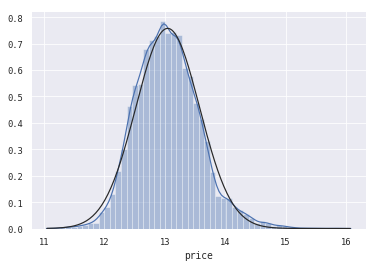

<Figure size 432x288 with 0 Axes>

In [169]:
sns.distplot(kcdata_log['price'], fit=norm)
fig = plt.figure()


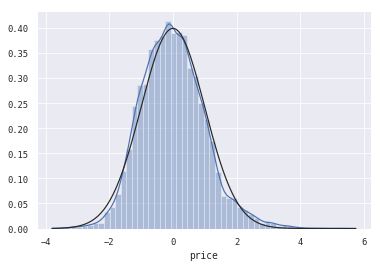

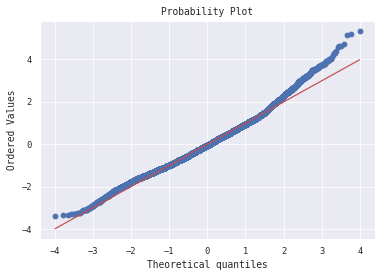

In [170]:
sns.distplot(kcdata_set['price'], fit=norm)
fig=plt.figure()
res = stats.probplot(kcdata_set['price'],plot=plt)

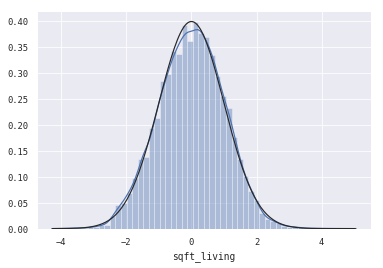

<Figure size 432x288 with 0 Axes>

In [171]:
sns.distplot(kcdata_set['sqft_living'], fit=norm)
fig=plt.figure()

Resources: https://medium.com/vickdata/four-feature-types-and-how-to-transform-them-for-machine-learning-8693e1c24e80

## IV. Model using statsmodels and sklearn

### Simple Linear Regression on area variables

In [173]:
import statsmodels.api as sms
from statsmodels.formula.api import ols

In [174]:
data_ols = kcdata_set.iloc[:,2:]
data_ols.dropna(inplace=True)

In [175]:
data_ols.columns

Index(['price', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement',
       'grade_3', 'grade_4', 'grade_5', 'grade_6', 'grade_7',
       ...
       'zipcode_98146', 'zipcode_98148', 'zipcode_98155', 'zipcode_98166',
       'zipcode_98168', 'zipcode_98177', 'zipcode_98178', 'zipcode_98188',
       'zipcode_98198', 'zipcode_98199'],
      dtype='object', length=226)

#### Univariate Regression

In [176]:
X = data_ols.sqft_living
y = data_ols.price

model = sms.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                 1.806e+04
Date:                Wed, 15 May 2019   Prob (F-statistic):               0.00
Time:                        23:54:53   Log-Likelihood:                -24082.
No. Observations:               21596   AIC:                         4.817e+04
Df Residuals:                   21595   BIC:                         4.817e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
sqft_living     0.6748      0.005    134.375      0.000       0.665       0.685
==============================================================================
Omnibus:                      123.586   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              114.131
Skew:                           0.143   Prob(JB):                     1.65e-25
Kurtosis:                       2.788   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [177]:
X = data_ols.sqft_basement
y = data_ols.price

model = sms.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     1599.
Date:                Wed, 15 May 2019   Prob (F-statistic):               0.00
Time:                        23:54:53   Log-Likelihood:                -29872.
No. Observations:               21596   AIC:                         5.975e+04
Df Residuals:                   21595   BIC:                         5.975e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
sqft_basement     2.4131      0.060     39.988      0.000       2.295       2.531
==============================================================================
Omnibus:                      640.415   Durbin-Watson:                   1.901
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              751.688
Skew:                           0.384   Prob(JB):                    5.93e-164
Kurtosis:                       3.497   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [178]:
X = data_ols.sqft_above
y = data_ols.price

model = sms.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                 1.130e+04
Date:                Wed, 15 May 2019   Prob (F-statistic):               0.00
Time:                        23:54:53   Log-Likelihood:                -26100.
No. Observations:               21596   AIC:                         5.220e+04
Df Residuals:                   21595   BIC:                         5.221e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
sqft_above     0.5861      0.006    106.290      0.000       0.575       0.597
==============================================================================
Omnibus:                      138.784   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              139.468
Skew:                           0.188   Prob(JB):                     5.19e-31
Kurtosis:                       2.883   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The square footage of house apart from basement seems to be significant to house price too. 

#### Let's put all variables into the model and let algorithm decide which variable to keep.

In [180]:
predictors = data_ols.drop('price', axis=1)
X = predictors
y = data_ols['price']

In [181]:
import statsmodels.api as sm
#from statsmodels.formula.api import ols

X_int = sm.add_constant(predictors)

model = sm.OLS(y, X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     733.9
Date:                Wed, 15 May 2019   Prob (F-statistic):               0.00
Time:                        23:56:01   Log-Likelihood:                -7554.7
No. Observations:               21596   AIC:                         1.555e+04
Df Residuals:                   21377   BIC:                         1.730e+04
Df Model:                         218                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                2.391e+11   5.26e+11      0.455      0.649   -7.91e+11    1.27e+12
sqft_living             0.2574      0.013     19.144      0.000       0.231       0.284
sqft_lot                2.3048      0.104     22.123      0.000       2.101       2.509
sqft_above              0.1674      0.012     13.582      0.000       0.143       0.192
sqft_basement           0.1754      0.072      2.438      0.015       0.034       0.316
grade_3              1.877e+10   4.13e+10      0.455      0.649   -6.21e+10    9.96e+10
grade_4              1.877e+10   4.13e+10      0.455      0.649   -6.21e+10    9.96e+10
grade_5              1.877e+10   4.13e+10      0.455      0.649   -6.21e+10    9.96e+10
grade_6              1.877e+10   4.13e+10      0.455      0.649   -6.21e+10    9.96e+10
grade_7              1.877e+10   4.13e+10      0.455      0.649   -6.21e+10    9.96e+10
grade_8              1.877e+10   4.13e+10      0.455      0.649   -6.21e+10    9.96e+10
grade_9              1.877e+10   4.13e+10      0.455      0.649   -6.21e+10    9.96e+10
grade_10             1.877e+10   4.13e+10      0.455      0.649   -6.21e+10    9.96e+10
grade_11             1.877e+10   4.13e+10      0.455      0.649   -6.21e+10    9.96e+10
grade_12             1.877e+10   4.13e+10      0.455      0.649   -6.21e+10    9.96e+10
grade_13             1.877e+10   4.13e+10      0.455      0.649   -6.21e+10    9.96e+10
floors_(0.0, 1.0]    5.813e+10   1.28e+11      0.455      0.649   -1.92e+11    3.09e+11
floors_(1.0, 1.5]    5.813e+10   1.28e+11      0.455      0.649   -1.92e+11    3.09e+11
floors_(1.5, 2.0]    5.813e+10   1.28e+11      0.455      0.649   -1.92e+11    3.09e+11
floors_(2.0, 3.5]    5.813e+10   1.28e+11      0.455      0.649   -1.92e+11    3.09e+11
view_0              -9.213e+10   2.03e+11     -0.455      0.649   -4.89e+11    3.05e+11
view_1              -9.213e+10   2.03e+11     -0.455      0.649   -4.89e+11    3.05e+11
bedroom_(1, 2]         -0.0813      0.027     -3.067      0.002      -0.133      -0.029
bedroom_(2, 3]         -0.0964      0.027     -3.592      0.000      -0.149      -0.044
bedroom_(3, 4]         -0.1032      0.028     -3.738      0.000      -0.157      -0.049
bedroom_(4, 5]         -0.1417      0.029     -4.870      0.000      -0.199      -0.085
bedroom_(5, 6]         -0.1698      0.035     -4.819      0.000      -0.239      -0.101
bedroom_(6, 11]        -0.3420      0.054     -6.393      0.000      -0.447      -0.237
bathroom_(0.5, 1.5]     0.3524      0.174      2.030      0.042       0.012       0.693
bathroom_(1.5, 2.0]     0.3813      0.174      2.195      0.028       0.041       0.722
bathroom_(2.0, 2.5]     0.4343      0.174      2.499      0.012       0.094       0.775
bathroom_(2.5, 5.0]     0.4784      0.174      2.751      0.006       0.137       0.819
bat

Although the adjusted R-square is high, many variables have p value > 0.05.

## Use sklearn

#You have to use numerical values in sklearn... has to transform to dummy variables...
https://www.scikit-yb.org/en/latest/api/features/rfecv.html

In [203]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [204]:
predictors = data_ols.drop('price', axis=1)
X = predictors
y = data_ols['price']

linreg = LinearRegression()
selector = RFE(linreg,n_features_to_select=100)
selector = selector.fit(X,y)

In [205]:
data_ols.columns

Index(['price', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement',
       'grade_3', 'grade_4', 'grade_5', 'grade_6', 'grade_7',
       ...
       'zipcode_98146', 'zipcode_98148', 'zipcode_98155', 'zipcode_98166',
       'zipcode_98168', 'zipcode_98177', 'zipcode_98178', 'zipcode_98188',
       'zipcode_98198', 'zipcode_98199'],
      dtype='object', length=226)

In [206]:
selector.support_

array([False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True,  True,  True,
        True,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [207]:
estimators = selector.estimator_
print(estimators.coef_)
print(estimators.intercept_)

[ 3.56813147e+11  3.56813147e+11  3.56813147e+11  3.56813147e+11
  3.56813147e+11  3.56813147e+11  3.56813147e+11  3.56813147e+11
  3.56813147e+11  3.56813147e+11  3.56813147e+11  1.46065694e+12
  1.46065694e+12  1.46065694e+12  1.46065694e+12 -4.57184058e+11
 -4.57184058e+11 -1.43202545e+12 -1.43202545e+12 -1.43202545e+12
 -1.43202545e+12 -1.43202545e+12  4.91595964e+12  4.91595964e+12
 -1.36051178e-01 -1.06643677e-01 -1.37840271e-01 -1.41117096e-01
 -1.53537750e-01 -1.58128023e-01 -3.73403973e+11 -3.73403973e+11
 -3.73403973e+11 -3.73403973e+11 -3.73403973e+11 -3.73403973e+11
 -3.73403973e+11 -3.73403973e+11 -3.73403973e+11 -3.73403973e+11
 -3.73403973e+11 -3.73403973e+11 -3.73403973e+11 -3.73403973e+11
 -3.73403973e+11 -3.73403973e+11 -3.73403973e+11 -3.73403973e+11
 -3.73403973e+11 -3.73403973e+11 -3.73403973e+11 -3.73403973e+11
 -3.73403973e+11 -3.73403973e+11 -3.73403973e+11 -3.73403973e+11
 -3.73403973e+11 -3.73403973e+11 -3.73403973e+11 -3.73403973e+11
 -3.73403973e+11 -3.73403

In [208]:
selected_columns = X.columns[selector.support_ ]
linreg.fit(X[selected_columns],y)
selected_columns

Index(['grade_3', 'grade_4', 'grade_5', 'grade_6', 'grade_7', 'grade_8',
       'grade_9', 'grade_10', 'grade_11', 'grade_12', 'grade_13',
       'floors_(0.0, 1.0]', 'floors_(1.0, 1.5]', 'floors_(1.5, 2.0]',
       'floors_(2.0, 3.5]', 'view_0', 'view_1', 'con_1', 'con_2', 'con_3',
       'con_4', 'con_5', 'waterfront_0.0', 'waterfront_1.0', 'year_1943',
       'year_2005', 'year_2007', 'year_2008', 'year_2009', 'year_2015',
       'zipcode_98001', 'zipcode_98002', 'zipcode_98003', 'zipcode_98004',
       'zipcode_98005', 'zipcode_98006', 'zipcode_98007', 'zipcode_98008',
       'zipcode_98010', 'zipcode_98011', 'zipcode_98014', 'zipcode_98019',
       'zipcode_98022', 'zipcode_98023', 'zipcode_98024', 'zipcode_98027',
       'zipcode_98028', 'zipcode_98029', 'zipcode_98030', 'zipcode_98031',
       'zipcode_98032', 'zipcode_98033', 'zipcode_98034', 'zipcode_98038',
       'zipcode_98039', 'zipcode_98040', 'zipcode_98042', 'zipcode_98045',
       'zipcode_98052', 'zipcode_98053', 'zip

In [209]:
X_int = sm.add_constant(predictors[selected_columns])

model = sm.OLS(y, X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     1002.
Date:                Thu, 16 May 2019   Prob (F-statistic):               0.00
Time:                        00:02:13   Log-Likelihood:                -12475.
No. Observations:               21596   AIC:                         2.514e+04
Df Residuals:                   21501   BIC:                         2.590e+04
Df Model:                          94                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -6.061e+10   1.41e+11     -0.430      0.667   -3.37e+11    2.15e+11
grade_3           -8.085e+10   1.88e+11     -0.430      0.667   -4.49e+11    2.87e+11
grade_4           -8.085e+10   1.88e+11     -0.430      0.667   -4.49e+11    2.87e+11
grade_5           -8.085e+10   1.88e+11     -0.430      0.667   -4.49e+11    2.87e+11
grade_6           -8.085e+10   1.88e+11     -0.430      0.667   -4.49e+11    2.87e+11
grade_7           -8.085e+10   1.88e+11     -0.430      0.667   -4.49e+11    2.87e+11
grade_8           -8.085e+10   1.88e+11     -0.430      0.667   -4.49e+11    2.87e+11
grade_9           -8.085e+10   1.88e+11     -0.430      0.667   -4.49e+11    2.87e+11
grade_10          -8.085e+10   1.88e+11     -0.430      0.667   -4.49e+11    2.87e+11
grade_11          -8.085e+10   1.88e+11     -0.430      0.667   -4.49e+11    2.87e+11
grade_12          -8.085e+10   1.88e+11     -0.430      0.667   -4.49e+11    2.87e+11
grade_13          -8.085e+10   1.88e+11     -0.430      0.667   -4.49e+11    2.87e+11
floors_(0.0, 1.0]  7.672e+10   1.78e+11      0.430      0.667   -2.73e+11    4.26e+11
floors_(1.0, 1.5]  7.672e+10   1.78e+11      0.430      0.667   -2.73e+11    4.26e+11
floors_(1.5, 2.0]  7.672e+10   1.78e+11      0.430      0.667   -2.73e+11    4.26e+11
floors_(2.0, 3.5]  7.672e+10   1.78e+11      0.430      0.667   -2.73e+11    4.26e+11
view_0             2.295e+11   5.33e+11      0.430      0.667   -8.16e+11    1.27e+12
view_1             2.295e+11   5.33e+11      0.430      0.667   -8.16e+11    1.27e+12
con_1             -2.472e+10   5.74e+10     -0.430      0.667   -1.37e+11    8.79e+10
con_2             -2.472e+10   5.74e+10     -0.430      0.667   -1.37e+11    8.79e+10
con_3             -2.472e+10   5.74e+10     -0.430      0.667   -1.37e+11    8.79e+10
con_4             -2.472e+10   5.74e+10     -0.430      0.667   -1.37e+11    8.79e+10
con_5             -2.472e+10   5.74e+10     -0.430      0.667   -1.37e+11    8.79e+10
waterfront_0.0    -1.335e+11    3.1e+11     -0.430      0.667   -7.41e+11    4.74e+11
waterfront_1.0    -1.335e+11    3.1e+11     -0.430      0.667   -7.41e+11    4.74e+11
year_1943            -0.1354      0.034     -3.978      0.000      -0.202      -0.069
year_2005            -0.1077      0.021     -5.107      0.000      -0.149      -0.066
year_2007            -0.1367      0.022     -6.221      0.000      -0.180      -0.094
year_2008            -0.1417      0.024     -6.024      0.000      -0.188      -0.096
year_2009            -0.1536      0.029     -5.258      0.000      -0.211      -0.096
year_2015            -0.1614      0.071     -2.286      0.022      -0.300      -0.023
zipcode_98001     -6.598e+09   1.53e+10     -0.430      0.667   -3.67e+10    2.35e+10
zipcode_98002     -6.598e+09   1.53e+10     -0.430      0.667   -3.67e+10

#### 

## Model-Validation

In [211]:
y = data_ols['price']
X = data_ols.drop(['price'], axis=1)

In [212]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)
print(len(X_train), len(X_test), len(y_train), len(y_test))

16197 5399 16197 5399


In [213]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()

In [214]:
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [215]:
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [216]:
from sklearn.metrics import mean_squared_error

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 0.11556761591262626
Test Mean Squarred Error: 0.126937964153784


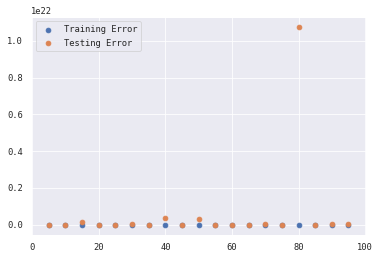

In [217]:
import random
random.seed(11)

train_err = []
test_err = []
t_sizes = list(range(5,100,5))
for t_size in t_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=t_size/100)
    linreg.fit(X_train, y_train)
    y_hat_train = linreg.predict(X_train)
    y_hat_test = linreg.predict(X_test)
    train_err.append(mean_squared_error(y_train, y_hat_train))
    test_err.append(mean_squared_error(y_test, y_hat_test))
plt.scatter(t_sizes, train_err, label='Training Error')
plt.scatter(t_sizes, test_err, label='Testing Error')
plt.legend()

There is one testing error but overall the model performs pretty well. 

## Appendix:

### Stepwise Selection

In [ ]:
import statsmodels.api as sm

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [ ]:
X = predictors
y = data_ols['price']

In [ ]:
result = stepwise_selection(X, y, verbose = True)
print(result)

In [ ]:
predictors[result];

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

X_int = sm.add_constant(predictors[result])

model = sm.OLS(y, X_int).fit()
model.summary()

The model produced by step-wise selection keeps variables with p-value < 0.05. However, the adjusted R-square is only 0.629 which is worse than the single variable model.